## The hypothesis of the perfect portfolio
#### 03.05.2019

In [1]:
# connection necessary packeges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

## Helpfull functions

In [2]:
# profitability of the portfolio
def port_mean(d, means, n_days=250):
    d = np.array(d)
    return np.sum(means * d) * n_days


# volatility of the portfolio
def port_vol(d, cov, n_days=250):
    d = np.array(d)
    return np.sqrt(np.dot(d.T, np.dot(cov * n_days, d)))


# best portfolio
def port_best(d, cov, means, n_days=250):
    d = np.array(d)
    mean = np.sum(means * d) * n_days
    vol = np.sqrt(np.dot(d.T, np.dot(cov * n_days, d)))
    return -(mean / vol)

    
# Vallue at Risk (VaR) of asset
def asset_VaR(df, alpha = 5):
    var = []
    col = list(df.columns)
    for i in col:
        num = sorted(list(df[i]))
        var.append(-np.percentile(num, 5))
    return var


# Portfolio Value at Risk 
def port_VaR(weights, var):
    a = np.array(weights)
    b = np.array(var)
    return np.dot(a, b)


# Flag
def flag(df, n_assets):
    df['Flag'] = 0
    for i in range(1, len(df.index)):
        b = i - 1
        if df.index.year[i] != df.index.year[b] or i == (len(df.index) - 1):
            df.iloc[i, n_assets] = 1
            

        

# filter dataframe
def filter_df(df, start, stop):
        df = df[df.index >= start]
        df = df[df.index <= stop]
        return df


# assets characteristic
def best(df, n_assets):
    start = str(df.index[0])[:10]
    stop = ''
    n = 0
    ind = []
    bnd = []
    ret = []
    rsk = []
    for i in df['Flag']:
        if i == 1:
            stop = str(df.index[n])[:10]
            temp = filter_df(df, start, stop)
            del temp['Flag']
            means = np.mean(temp)
            cov = np.cov(temp, rowvar = False)
            n_days = len(temp.index)
            w_initial = n_assets * [1. / n_assets]
            bnds = tuple((0, 1) for x in range(n_assets))
            cons=({'type':'eq','fun':lambda x:sum(x)-1})
            best = sco.minimize(port_best, w_initial, (cov, means, n_days),
                                method = 'SLSQP', bounds = bnds, constraints = cons)
            ind.append(best['x'][0])
            bnd.append(best['x'][1])
            summ = sum(best['x'])
            ret.append(port_mean(best['x'], means, n_days))
            rsk.append(port_vol(best['x'], cov, n_days))                       
            n += 1
        else:
            n += 1
            if stop != '' or start == stop:
                start = stop
    res = pd.DataFrame({'Index': ind, 'Bond': bnd, 'Sum': summ, 'Return': ret, 'Risk': rsk})
    return res

In [3]:
# data parseemp
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
# download and calculate data
index = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/MOEXBC_c.csv'
                    , header=0, index_col=0, parse_dates={'Index_Date': [0]}, date_parser=dateparse, sep=';')
bond = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/RGBITR_c.csv'
                    , header=0, index_col=0, parse_dates={'Index_Date': [0]}, date_parser=dateparse, sep=';')
index_up = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/MOEXBC_add.csv'
                    , header=0, index_col=0, parse_dates={'Index_Date': [0]}, date_parser=dateparse, sep=';')
n_assets = 2

In [4]:
temp = []
for i in index.columns.values:
    if i == 'CLOSE':
        continue
    temp.append(i)

In [5]:
for i in temp:
    del index[i]
    del bond[i]
    del index_up[i]

In [6]:
# get daily returns
main = pd.merge(index, bond, left_index = True, right_index = True)
main = main.apply(lambda x: np.log(x / x.shift(1)))
main.dropna(inplace = True)
main.columns = ['Blue Chips', 'Bond index']
main.index.name = 'Date'
flag(main, n_assets)
print('Number of settlement periods: ' + str(sum(main.Flag)))
main.head()

Number of settlement periods: 8


,Blue Chips,Bond index,Flag
Date,,,
2012-04-03,0.018686,0.000211,0
2012-04-04,-0.023290,-0.000986,0
2012-04-05,0.008678,0.000141,0
2012-04-06,-0.018159,-0.000564,0
2012-04-09,0.007753,-0.001129,0


In [7]:
ans = best(main, n_assets)
ans['Index'] = ans['Index'].apply(lambda x: round(x, 4))
ans['Bond'] = ans['Bond'].apply(lambda x: round(x, 4))
ans['Return'] = ans['Return'].apply(lambda x: str(round(x * 100, 2)) + '%')
ans['Risk'] = ans['Risk'].apply(lambda x: str(round(x * 100, 2)) + '%')
ans.index = range(2012, 2020)
ans

,Index,Bond,Sum,Return,Risk
2012,0.0000,1.0000,1.0,9.68%,2.56%
2013,0.0000,1.0000,1.0,3.85%,5.04%
2014,1.0000,0.0000,1.0,-6.14%,24.39%
2015,0.0812,0.9188,1.0,25.71%,8.56%
2016,0.0337,0.9663,1.0,14.43%,4.57%
2017,0.0000,1.0000,1.0,12.33%,2.41%
2018,0.3088,0.6912,1.0,6.1%,7.1%
2019,0.0985,0.9015,1.0,4.92%,1.77%


## Calculation period

In [8]:
c_period = main.copy()
c_period = c_period[c_period.index <= '2014-01-01']
del c_period['Flag']
c_period.head()

,Blue Chips,Bond index
Date,,
2012-04-03,0.018686,0.000211
2012-04-04,-0.023290,-0.000986
2012-04-05,0.008678,0.000141
2012-04-06,-0.018159,-0.000564
2012-04-09,0.007753,-0.001129


In [9]:
c_period.iloc[0] = {'Blue Chips': 1, 'Bond index': 1}
for i in range(1, len(c_period)):
    b = i - 1
    c_period.iloc[i, 0] = c_period.iloc[b, 0] * (1 + c_period.iloc[i, 0])
    c_period.iloc[i, 1] = c_period.iloc[b, 1] * (1 + c_period.iloc[i, 1])
c_period.tail()

,Blue Chips,Bond index
Date,,
2013-12-24,0.940429,1.139202
2013-12-25,0.936730,1.139483
2013-12-26,0.937157,1.138534
2013-12-27,0.931977,1.139342
2013-12-30,0.937329,1.140817


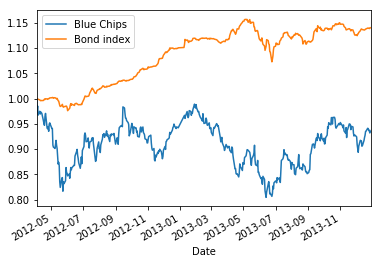

In [10]:
c_period.plot()

In [11]:
# Leight of calculation period
leng = len(main) - len(c_period)

In [12]:
# Date of calculation period
work_index = main.index[len(c_period):]

## Let's build the area of possible values for Blue Chips and Bond index

In [13]:
ind = index_up.copy()
ind = ind.apply(lambda x: np.log(x / x.shift(1)))
ind.dropna(inplace = True)
bnd = bond.copy()
bnd = bnd[bnd.index <= '2014-01-01']
bnd = bnd.apply(lambda x: np.log(x / x.shift(1)))
bnd.dropna(inplace = True)

In [14]:
bc_i = np.mean(ind['CLOSE'])
bn_i = np.mean(bnd['CLOSE'])
bc_r = np.std(ind['CLOSE'])
bn_r = np.std(bnd['CLOSE'])

In [15]:
print('Blue chipls return: ', round(np.mean(ind['CLOSE']) * 100, 4), '%', sep='')
print('Bond index return: ', round(np.mean(bnd['CLOSE']) * 100, 4), '%', sep='')
print('Blue chipls risk: ', round(np.std(ind['CLOSE']) * 100, 4), '%', sep='')
print('Bond index risk: ', round(np.std(bnd['CLOSE']) * 100, 4), '%', sep='')

Blue chipls return: 0.0389%
Bond index return: 0.0302%
Blue chipls risk: 1.6268%
Bond index risk: 0.2689%


In [16]:
ind.iloc[0] = 1
for i in range(1, len(ind)):
    b = i - 1
    ind.iloc[i, 0] = ind.iloc[b, 0] * (1 + ind.iloc[i, 0])
bnd.iloc[0] = 1
for i in range(1, len(bnd)):
    b = i - 1
    bnd.iloc[i, 0] = bnd.iloc[b, 0] * (1 + bnd.iloc[i, 0])

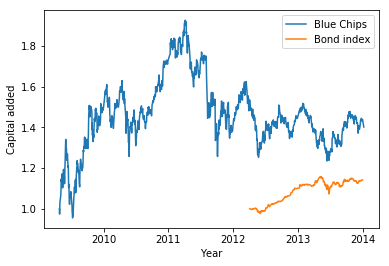

In [17]:
_=plt.plot(ind.index, ind['CLOSE'], label = 'Blue Chips')
_=plt.plot(bnd.index, bnd['CLOSE'], label = 'Bond index')
_=plt.xlabel('Year')
_=plt.ylabel('Capital added')
_=plt.legend()

In [18]:
a = pd.DataFrame([[np.random.normal(bc_i, bc_r) for i in range(10)] for j in range(leng)])
a.iloc[0] = index['CLOSE'][0]
for i in a.columns.values:
    for j in range(1, len(a[i])):
        b = j - 1
        a[i][j] = a[i][b] * (1 + a[i][j])
a.index = work_index
a.columns = ['test' + str(i) for i in range(10)]
a.tail()

,test0,test1,test2,test3,test4,test5,test6,test7,test8,test9
Date,,,,,,,,,,
2019-04-16,14898.111619,19548.479238,24742.261530,11978.439308,7737.617784,7119.519344,39707.239295,17656.374543,17424.022240,5081.058961
2019-04-17,14680.137431,19232.593273,24664.765940,11653.017786,7664.608437,7263.689255,39125.515204,17237.067762,17184.569356,5007.522359
2019-04-18,14245.783919,19070.593234,24064.818542,11484.322831,7931.371824,7206.474208,38737.098303,17735.267271,17146.390451,5021.349532
2019-04-19,14169.664794,18904.227044,24309.508341,11412.601795,7914.071530,7239.772136,37489.576632,17925.777285,17313.931354,4955.905829
2019-04-22,14131.132072,19419.157128,23277.949275,11247.205330,8164.496371,7276.036027,37706.038404,17695.035827,17551.491143,4929.079942


In [19]:
b = pd.DataFrame([[np.random.normal(bn_i, bn_r) for i in range(10)] for j in range(leng)])
b.iloc[0] = bond['CLOSE'][len(bnd)]
for i in b.columns.values:
    for j in range(1, len(b[i])):
        c = j - 1
        b[i][j] = b[i][c] * (1 + b[i][j])
b.index = work_index
b.columns = ['test' + str(i) for i in range(10)]
b.tail()

,test0,test1,test2,test3,test4,test5,test6,test7,test8,test9
Date,,,,,,,,,,
2019-04-16,467.837522,451.295819,479.913811,539.402893,560.613127,508.678535,519.819325,509.993922,480.543487,492.116681
2019-04-17,469.539012,452.873637,482.477752,539.694443,560.741584,509.595780,518.814704,513.300402,480.284830,492.909162
2019-04-18,470.406343,451.771627,484.673099,536.246107,559.193793,510.138547,517.725991,515.333911,480.207809,491.182505
2019-04-19,471.084263,452.234174,484.817415,535.254134,560.650194,508.864899,516.078287,514.899227,480.805392,491.735246
2019-04-22,472.604177,452.177147,485.436331,537.147629,560.195119,508.461026,515.289400,517.203520,482.202682,489.122493


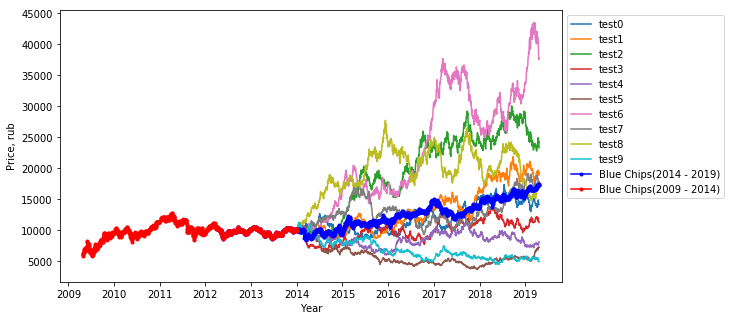

In [20]:
_=plt.figure(figsize = (9, 5))
for i in a.columns.values:
    _=plt.plot(a.index, a[i])
_=plt.plot(index.index, index['CLOSE'], color = 'b', marker = '.', label = 'Blue Chips(2014 - 2019)')
_=plt.plot(index_up.index, index_up['CLOSE'], color = 'r', marker = '.', label = 'Blue Chips(2009 - 2014)')
_=plt.xlabel('Year')
_=plt.ylabel('Price, rub')
_=plt.legend(bbox_to_anchor=(1, 1))

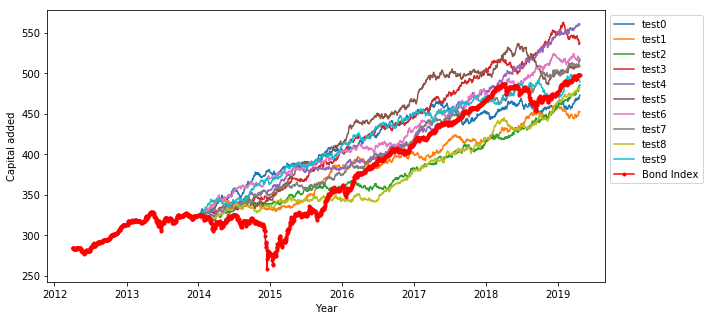

In [21]:
_=plt.figure(figsize = (10, 5))
for i in b.columns.values:
    _=plt.plot(b.index, b[i])
_=plt.plot(bond.index, bond['CLOSE'], color = 'r', marker = '.', label = 'Bond Index')
_=plt.xlabel('Year')
_=plt.ylabel('Capital added')
_=plt.legend(bbox_to_anchor=(1, 1))

## Best portfolio

In [22]:
np.random.seed()

In [23]:
a = pd.DataFrame([[np.random.normal(bc_i, bc_r) for i in range(100)] for j in range(leng)])
a.iloc[0] = index['CLOSE'][0]
for i in a.columns.values:
    for j in range(1, len(a[i])):
        b = j - 1
        a[i][j] = a[i][b] * (1 + a[i][j])
a.index = work_index
a.columns = ['test_' + str(i) for i in range(100)]
a = a.apply(lambda x: np.log(x / x.shift(1)))
a.dropna(inplace = True)

In [24]:
b = pd.DataFrame([[np.random.normal(bn_i, bn_r) for i in range(100)] for j in range(leng)])
b.iloc[0] = bond['CLOSE'][len(bnd)]
for i in b.columns.values:
    for j in range(1, len(b[i])):
        c = j - 1
        b[i][j] = b[i][c] * (1 + b[i][j])
b.index = work_index
b.columns = ['test_' + str(i) for i in range(100)]
b = b.apply(lambda x: np.log(x / x.shift(1)))
b.dropna(inplace = True)

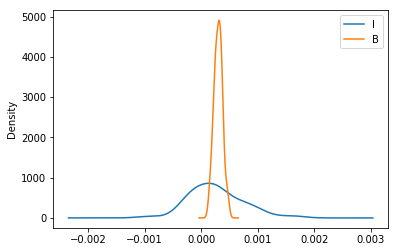

In [25]:
all_means = pd.DataFrame({'I': np.mean(a), 'B': np.mean(b)})
all_means.plot.kde()

In [26]:
np.mean(all_means)

I    0.000262
B    0.000302
dtype: float64

In [27]:
all_std = pd.DataFrame({'I': np.std(a), 'B': np.std(b)})
np.mean(all_std)

I    0.016276
B    0.002680
dtype: float64

In [28]:
a = a.apply(lambda x: x / 100)
b = b.apply(lambda x: x / 100)

In [29]:
best_port = pd.DataFrame({'Index': list(a.sum(axis = 1)), 'Bond': list(b.sum(axis = 1))})
best_port.index = work_index[1:]

In [30]:
means = np.mean(best_port)
cov = np.cov(best_port, rowvar = False)
n_days = 252
var = asset_VaR(best_port)

In [31]:
w_initial = n_assets * [1. / n_assets]
bnds = tuple((0, 1) for x in range(n_assets))
cons=({'type':'eq','fun':lambda x:sum(x)-1})
best = sco.minimize(port_best, w_initial, (cov, means, n_days),
                                method = 'SLSQP', bounds = bnds, constraints = cons)

In [32]:
best['x']

array([0.02779727, 0.97220273])

In [33]:
port_VaR(best['x'], var)

0.00018665979479908895

In [34]:
port_mean(best['x'], means)

0.07516001549077059

In [35]:
port_vol(best['x'], cov)

0.004142122286890114

In [36]:
i = index[index.index >= '2014-01-01']
b = bond[bond.index >= '2014-01-01']

In [37]:
test = pd.DataFrame({'Blue Chips': i['CLOSE'], 
                'Bond index': b['CLOSE']})
test['Portfolio'] = test['Blue Chips'] * best['x'][0] + test['Bond index'] * best['x'][1]
test.index.name = 'Date'

In [38]:
test = test.apply(lambda x: np.log(x) - np.log(x).shift(1))
test.dropna(inplace = True)
test.head()

,Blue Chips,Bond index,Portfolio
Date,,,
2014-01-08,-0.003360,0.000615,-0.001235
2014-01-09,0.002202,-0.001693,0.000120
2014-01-10,0.001949,-0.000585,0.000596
2014-01-13,0.006242,0.001078,0.003491
2014-01-14,-0.005904,0.000492,-0.002495


In [39]:
test.iloc[0] = 1
for i in test.columns.values:
    for j in range(1, len(test[i])):
        c = j - 1
        test[i][j] = test[i][c] * (1 + test[i][j])
test.tail()

,Blue Chips,Bond index,Portfolio
Date,,,
2019-04-16,1.586320,1.505684,1.583173
2019-04-17,1.592625,1.507047,1.587029
2019-04-18,1.586851,1.505410,1.583295
2019-04-19,1.588309,1.506167,1.584420
2019-04-22,1.602309,1.507257,1.591970


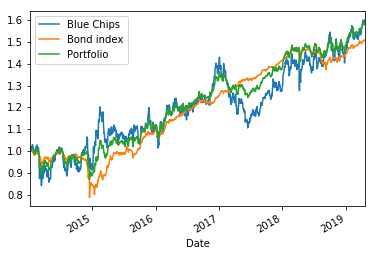

In [40]:
test.plot()